In [1]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

def find_bounding_box(image, threshold=0.05, verbose=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    box = [[9999, 9999], [0, 0]]
    
    # for x, loop over columns until sum > threshold    
    height = image.shape[1]
    for x in range(height-1):
        sum_row = np.sum(gray[:, x])
        if sum_row > threshold*height*255:
            box[0][0] = int(min(box[0][0], x))
        
        sum_row = np.sum(gray[:, -(x+1)])
        if sum_row > threshold*height*255:
            box[1][0] = int(max(box[1][0], height - x))
    
    # for y, loop over rows until sum > threshold    
    width = image.shape[0]
    for y in range(width-1):
        sum_row = np.sum(gray[y, :])
        if sum_row > threshold*width*255:
            box[0][1] = int(min(box[0][1], y))
            
        sum_row = np.sum(gray[-(y+1), :])
        if sum_row > threshold*width*255:
            box[1][1] = int(max(box[1][1], width-y))
    
    if verbose:
        print 'min: (%i, %i)' % (box[0][0], box[0][1])   
        print 'max: (%i, %i)' % (box[1][0], box[1][1])
        
    return box

def crop_image(image, box):
    output = image.copy()
    return output[box[0][1]:box[1][1], box[0][0]:box[1][0]]

def scale_fill_image(image, final_width=512, final_height=512, verbose=False):
    # assume we have a perfect square image that we want all of    
    width = image.shape[1]
    height = image.shape[0]
    
    desired_width = [0, width]
    desired_height = [0, height]       
    
    # determine which is larger dimension, keep all of lesser dim
    if height > width:
        # taller that wider      
        diff = height - width
        #split difference and take from top and bottom
        desired_height[0] = int(diff/2)
        desired_height[1] = int(height - diff/2)
        if verbose:
            print 'height (%i) > width (%i)' % (height, width)
            print 'diff (%i)' % diff
    else:   
        # wider than tall
        diff = width - height
        # split different and take from each side
        desired_width[0] = int(diff/2)
        desired_width[1] = int(width - diff/2)        
        if verbose:            
            print 'width (%i) > height (%i)' % (width, height)
            print 'diff (%i)' % diff
        
    sliced_img = image[
        desired_height[0]:desired_height[1], 
        desired_width[0]:desired_width[1]
    ]
    
    if verbose:
        print 'Dimensions (%i, %i), (%i, %i)' % (desired_width[0], 
                                                 desired_height[0], 
                                                 desired_width[1], 
                                                 desired_height[1])
    
    return cv2.resize(sliced_img,
                      (final_width, final_height), 
                      interpolation = cv2.INTER_AREA)

def crop_scale_image(image):
    box = find_bounding_box(image)
    cropped = crop_image(image, box)
    scaled = scale_fill_image(cropped)
    return scaled

def normalize_image(image):
    output = image.copy()
    output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
    
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(output)
    return cl1

def process_file(path, filename, out_path, verbose=False):
    img = cv2.imread(join(path, filename))
    output = scale_fill_image(img)
    output = normalize_image(output)
    cv2.imwrite(join(out_path, filename), output)
    if verbose:
        print 'Wrote "%s" to "%s"' % (filename, join(out_path, filename))
        
def process_images(path, out_path, verbose=False):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    
    if verbose:
        print 'Processing %i images at "%s"' (len(files), path)
        
    for f in files:
        process_file(path, f, out_path, verbose)
        
    print 'Processing complete.'

In [6]:
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

def load_images(path, batch=1000):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    images = []
    for i in range(batch):
        images.append(cv2.imread(join(path, files[i])))
        
    return images

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [7]:
path = 'output'
real_path = 'C:\\_ml_data\\Retinopathy\\processed'
images = load_images(real_path)
print len(images)

1000


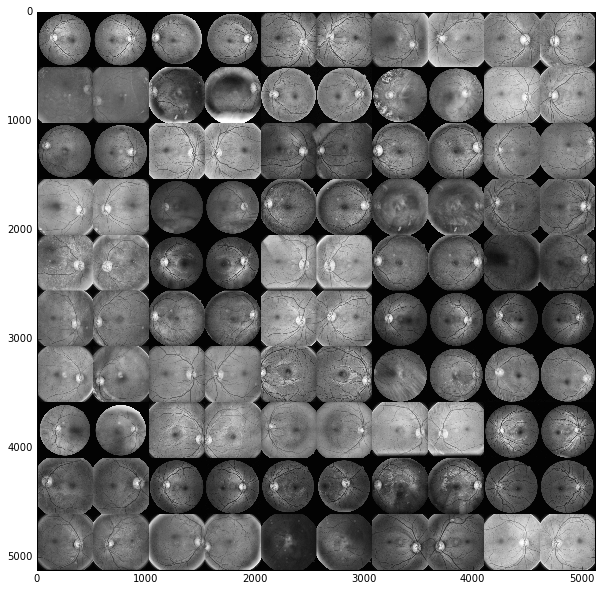

In [15]:
rows = []
for i in range(10):
    rows.append(np.concatenate(images[i*10:(i+1)*10], axis=1))
stacked = np.concatenate(rows, axis=0)
plt.imshow(stacked)

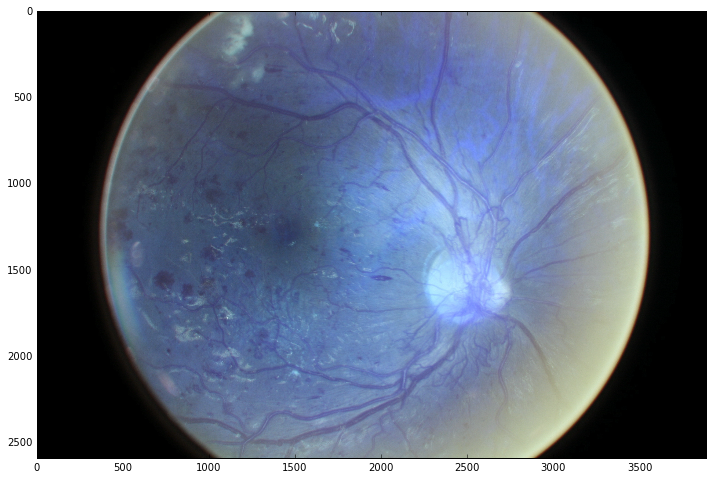

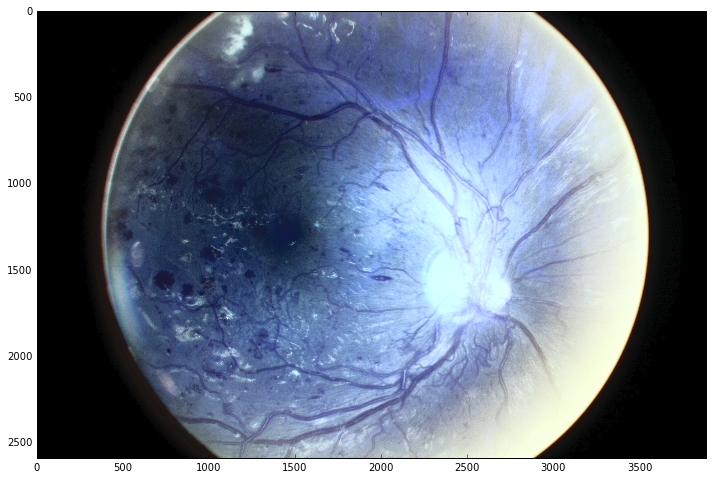

In [21]:
import cv2
import numpy as np

path = 'samples/16_left.jpeg'

img = cv2.imread(path)

def normalize_color_hist(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_output


img_output = normalize_color_hist(img)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(img_output)